In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: <i>Data pre-processing</i>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
datos = pd.read_csv("./drive/My Drive/Colab Notebooks/data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [0]:
obj_rg = open("./drive/My Drive/Colab Notebooks/data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [0]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [0]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [0]:
np.min(X_rg)

BB9     5.692781
BB10    5.733848
BB17    5.686571
BB19    5.735536
BB20    6.016590
BB21    6.131968
BB11    6.113390
BB12    5.891730
BB18    5.822536
dtype: float64

In [0]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [0]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [0]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [0]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.1))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [0]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [0]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


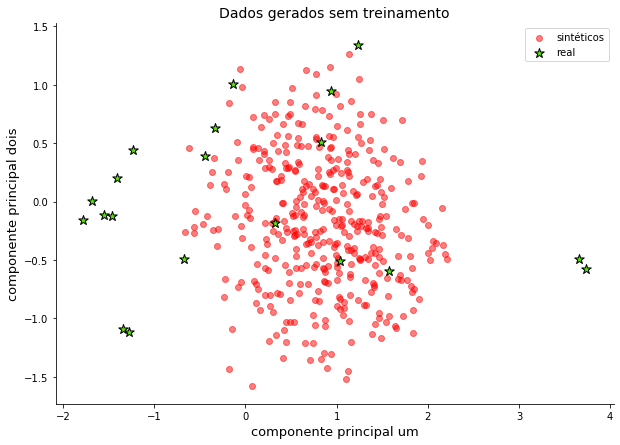

In [0]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [0]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [0]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [0]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall

In [0]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [0]:
w_i = gan.get_weights()
w_i[0][0][0]

-0.0906318

In [0]:
g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.752147],[Generator::loss: 0.555366], 1.142318[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.772240],[Generator::loss: 0.549908], 0.016293[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.788823],[Generator::loss: 0.582354], 0.014953[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.784684],[Generator::loss: 0.556831], 0.014218[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.784762],[Generator::loss: 0.551010], 0.014548[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.834177],[Generator::loss: 0.513102], 0.014657[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.791434],[Generator::loss: 0.585491], 0.014260[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.807245],[Generator::loss: 0.539956], 0.014788[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.782767],[Generator::loss: 0.566404], 0.014782[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.811273],[Generator::loss: 0.561791], 0.015273[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.806178],[Generator::loss: 0.573925], 

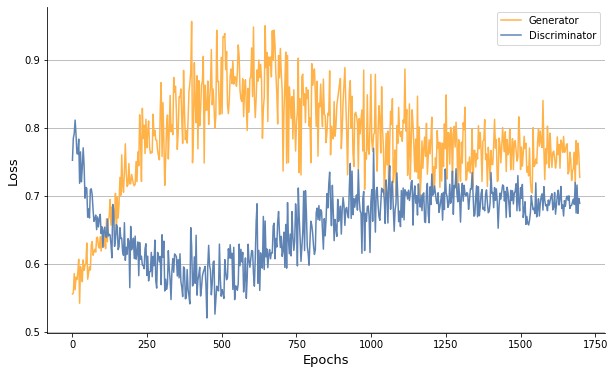

In [0]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

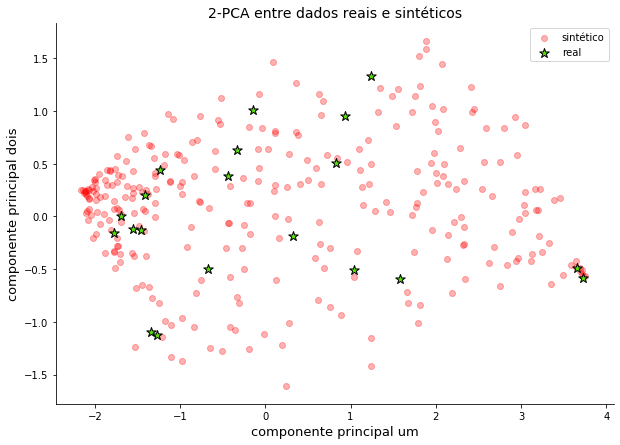

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
#ENTRENANDO EL CLASIFICADOR SOLO CON LOS GENES DE REFERENCIA

from sklearn.svm import OneClassSVM
#nu=0.0112

clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=1/9, max_iter=-1).fit(X_nov) #0.0138

print("train recall score: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train recall score in the RG: ", recall_score(np.ones(14), clf.predict(X_train[:14])))
print("test recall score in the RG: ", accuracy_score(np.ones(6),clf.predict(X_train[14:]) ))
print("recall em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train recall score:  0.9808917197452229
train recall score in the RG:  0.9285714285714286
test recall score in the RG:  0.8333333333333334
recall em todos os genes de referência:  0.9
------------------------------------------------------


((905, 9), (3263, 9))

In [0]:
sc, df = clf.score_samples(X_nov), clf.decision_function(X_nov)


In [0]:
sc[np.where(df<0)], np.where(df<0)

(array([1.1361529 , 1.13604706, 1.13607957, 1.13605195, 1.13614948,
        1.13625129]), (array([ 10,  21,  50, 150, 211, 282]),))

In [0]:
np.sort(sc)[:len(sc[np.where(df<0)])] == np.sort(sc[np.where(df<0)])

array([ True,  True,  True,  True,  True,  True])

In [0]:
min_pre = np.inf
l_dist = []
for i in range(300):
    t_i = time()
    noise_input = 50
    ep = 1700
    #Gerador
    optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
    #optimizerG = SGD(lr=0.00011, momentum=0.92)
    obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
    G = obj_G.compileG()
    # Discriminador
    optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
    #optimizerD = SGD(lr=0.001, momentum=0.9)
    objD = Discriminator((X_train.shape[1],), optimizerD)
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    w_i = gan.get_weights().copy()
    g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(50):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        d = []
        for g in range(X_train.shape[0]):
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d)))
    l_dist.append(np.mean(np.array(l_pre)))
    if np.mean(np.array(l_pre)) < min_pre:
        min_pre = np.mean(np.array(l_pre))
        w_best = w_i
    t_f = time()
    print("iteração: ",i," ", np.round(t_f-t_i,4), "[s]")

iteração:  0   28.1244 [s]
iteração:  1   29.0043 [s]
iteração:  2   29.6554 [s]
iteração:  3   30.1778 [s]
iteração:  4   31.0237 [s]
iteração:  5   31.7152 [s]
iteração:  6   32.5174 [s]
iteração:  7   34.13 [s]
iteração:  8   34.398 [s]
iteração:  9   35.7331 [s]
iteração:  10   35.7742 [s]
iteração:  11   36.734 [s]
iteração:  12   37.2818 [s]
iteração:  13   37.6965 [s]
iteração:  14   38.5683 [s]
iteração:  15   39.3911 [s]
iteração:  16   40.4455 [s]
iteração:  17   41.1083 [s]
iteração:  18   41.712 [s]
iteração:  19   41.8431 [s]
iteração:  20   42.7374 [s]
iteração:  21   43.6976 [s]
iteração:  22   44.0777 [s]
iteração:  23   44.7853 [s]
iteração:  24   46.3318 [s]
iteração:  25   46.2562 [s]
iteração:  26   47.4647 [s]
iteração:  27   48.7723 [s]
iteração:  28   49.1695 [s]
iteração:  29   49.5849 [s]
iteração:  30   51.4226 [s]
iteração:  31   52.5793 [s]
iteração:  32   52.883 [s]
iteração:  33   53.759 [s]
iteração:  34   54.063 [s]
iteração:  35   54.8659 [s]
iteração: 

KeyboardInterrupt: ignored

In [0]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_338 (Sequential)  (None, 9)                 11559     
_________________________________________________________________
sequential_339 (Sequential)  (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [0]:
gan.get_weights()[0][0][0]

-0.24416424

In [0]:
gan.set_weights(w_best)
gan.get_weights()[0][0][0]

-0.18735644

In [0]:
g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.701279],[Generator::loss: 0.896895], 33.517858[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.708471],[Generator::loss: 0.845350], 0.049030[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.710123],[Generator::loss: 0.867165], 0.046022[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.706635],[Generator::loss: 0.906326], 0.050200[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.725346],[Generator::loss: 0.892688], 0.052005[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.708596],[Generator::loss: 0.785187], 0.045883[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.707538],[Generator::loss: 0.878278], 0.047631[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.721583],[Generator::loss: 0.890841], 0.038450[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.722486],[Generator::loss: 0.844270], 0.038302[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.718200],[Generator::loss: 0.806336], 0.041853[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.713599],[Generator::loss: 0.824897],

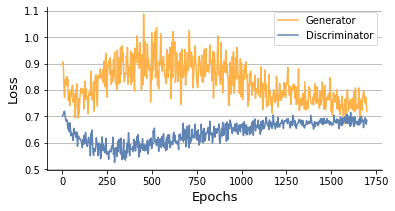

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/loss.svg');

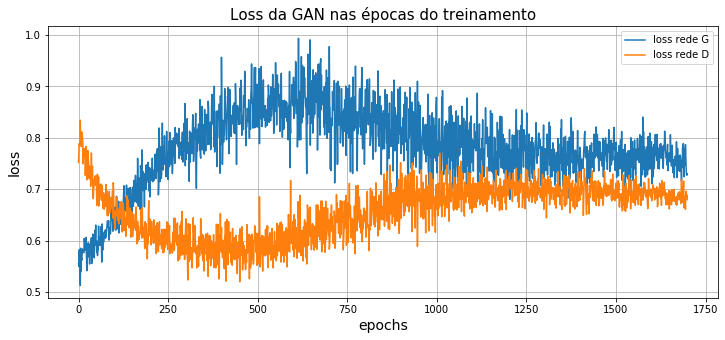

In [0]:
fig = plt.figure(figsize=(12,5))

plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

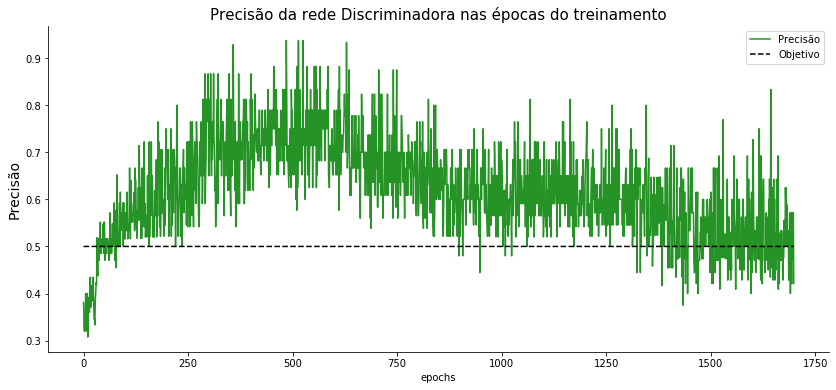

In [0]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

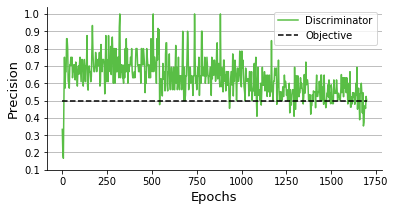

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_precision, color="#59BE45", alpha=1, label="Discriminator");
plt.plot(rr,np.ones(len(short_precision))*.5,
         color="black", ls="--", label="Objective");
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
           np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
plt.grid(axis="y")
plt.legend();
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/precision.svg');

In [0]:
#gan.save("./drive/My Drive/Colab Notebooks/data/best_gan27012020.h5")

In [0]:
from tensorflow.keras.models import load_model

gan_save = load_model("./drive/My Drive/Colab Notebooks/data/best_gan27012020.h5")
weights_save = gan_save.get_weights()
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()
gan.set_weights(weights_save)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Dimension del ruido de entrada:  50
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


(20, 2) (300, 2)


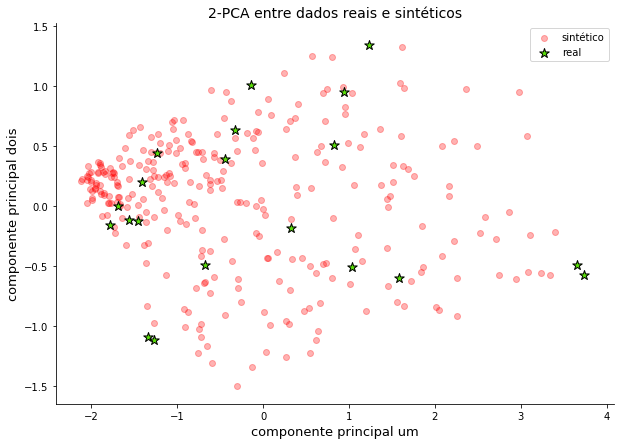

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(0, 1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
t_i = time()
m_precision = []
m_recall = []
m_f1score = []
m_accuracy = []
for i in range(10000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    m_precision.append(precision_score(y_test, y_predict))
    m_recall.append(recall_score(y_test, y_predict))
    m_f1score.append(f1_score(y_test, y_predict))
    m_accuracy.append(accuracy_score(y_test, y_predict))
t_f = time()
print("tempo de execução: ", t_f-t_i, "[s]")

tempo de execução:  74.35082483291626 [s]


In [0]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

### Boxplot das métricas do Discriminador

In [0]:
[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(m_precision))
[rl, rq1, rq2, rq3, ru], routs = boxtplot_values(np.array(m_recall))
[fl, fq1, fq2, fq3, fu], fouts = boxtplot_values(np.array(m_f1score))
[al, aq1, aq2, aq3, au], aouts = boxtplot_values(np.array(m_accuracy))

In [0]:
cats = ["Accuray", "Precision", "F1-score"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=300,) # title="Discriminator metrics"


p.segment(cats, [aq3,pq3,fq3], cats, [au,pu,fu], line_color="black")
p.segment(cats, [al,pl,fl], cats, [aq1,pq1,fq1], line_color="black")
# boxes
p.vbar(cats, 0.4, [aq2,pq2,fq2], [aq3,pq3,fq3], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.4, [aq1,pq1,fq1], [aq2,pq2,fq2], fill_color="#3B8686", line_color="black")
# whiskers
p.rect(cats, [al,pl,fl], 0.2, 0.0001, line_color="black")
p.rect(cats, [au,pu,fu], 0.2, 0.0001, line_color="black")

p.circle([cats[0] for i in range(len(np.unique(aouts)))], np.unique(aouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[1] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[2] for i in range(len(np.unique(fouts)))], np.unique(fouts),
         size=6, color="#F38630", fill_alpha=0.6)

p.legend.background_fill_alpha = 0.0
show(p)

/usr/local/lib/python3.6/dist-packages/bokeh/models/plots.py:767: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [0]:
np.arange(0.2,1,0.05)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95])

In [0]:
print("----------------------------")
print("---- accuracy metrics -----")
print("----------------------------")
print("mean accuracy: ", np.round(np.mean(m_accuracy),4))
print("median accuracy: ", np.round(np.median(m_accuracy),4))
print("std accuracy: ", np.round(np.std(m_accuracy),4))
print("----------------------------")
print("---- precision metrics -----")
print("----------------------------")
print("mean precision: ", np.round(np.mean(m_precision),4))
print("median precision: ", np.round(np.median(m_precision),4))
print("std precision: ", np.round(np.std(m_precision),4))
print("----------------------------")
print("---- recall metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_recall),4))
print("median recall: ", np.round(np.median(m_recall),4))
print("std recall: ", np.round(np.std(m_recall),4))
print("----------------------------")
print("---- f1-score metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_f1score),4))
print("median recall: ", np.round(np.median(m_f1score),4))
print("std recall: ", np.round(np.std(m_f1score),4))

----------------------------
---- accuracy metrics -----
----------------------------
mean accuracy:  0.5591
median accuracy:  0.55
std accuracy:  0.056
----------------------------
---- precision metrics -----
----------------------------
mean precision:  0.5607
median precision:  0.5455
std precision:  0.0597
----------------------------
---- recall metrics -----
----------------------------
mean recall:  0.6
median recall:  0.6
std recall:  0.0
----------------------------
---- f1-score metrics -----
----------------------------
mean recall:  0.5781
median recall:  0.5714
std recall:  0.0313


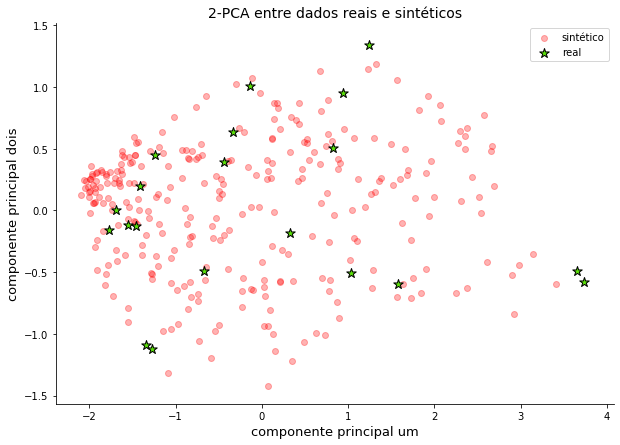

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [0]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 5000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  40.267091035842896 [s]
0.11176786343069028 2710


In [0]:
c_v = []
for i in dt_cv.keys():
    c_v.append(dt_cv[i][0])

0.13411627842661655


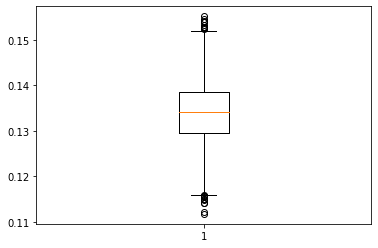

In [0]:
print(np.median(c_v))
plt.boxplot(c_v,);

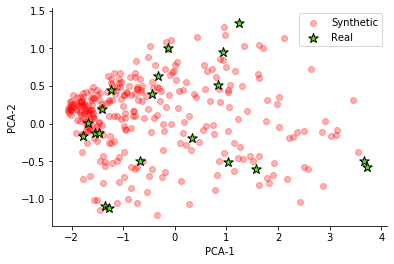

In [0]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="Synthetic", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend(loc="upper right");
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/new_data.svg');

In [0]:
#ENTRENANDO EL CLASIFICADOR SOLO CON LOS GENES DE REFERENCIA

from sklearn.svm import OneClassSVM
#nu=0.138

X_normal = X_train
clf = OneClassSVM(kernel="rbf", nu=0.0112, gamma=1/9).fit(X_normal[:14]) #0.0138

print("train accuracy: ", accuracy_score(np.ones(14),clf.predict(X_normal[:14])))
print("test accuracy in the RG: ", accuracy_score(np.ones(6),clf.predict(X_normal[14:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_normal.shape[0]),clf.predict(X_normal)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train accuracy:  0.6428571428571429
test accuracy in the RG:  0.6666666666666666
accuray em todos os genes de referência:  0.65
------------------------------------------------------


((680, 9), (3488, 9))

In [0]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
X_nov.shape

(314, 9)

train accuracy in the augmented data:  0.9808917197452229
train accuracy in the RG:  0.8571428571428571
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.85
------------------------------------------------------
train accuracy in the augmented data:  0.9808917197452229
train accuracy in the RG:  0.8571428571428571
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.85
accuracy de solo datos sintéticos:  0.9633333333333334


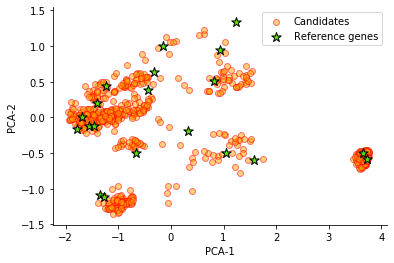

In [0]:

from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("train accuracy in the augmented data: ", accuracy_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", accuracy_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", accuracy_score(np.ones(7),clf.predict(X_train[13:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

print("train accuracy in the augmented data: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", recall_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", recall_score(np.ones(7),clf.predict(X_train[13:])))
print("accuray em todos os genes de referência: ", recall_score(np.ones(X_train.shape[0]),clf.predict(X_train)))

print("accuracy de solo datos sintéticos: ", recall_score(np.ones(3000),
                                                          clf.predict(G.predict(np.random.normal(0, 1, (3000, noise_input))))))
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/candidates.svg');

### One-class classification with SVM

In [0]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9808917197452229
score nos genes de referência de treinamento:  0.8571428571428571
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.85


In [0]:
#gan.save("./data/best_gan.h5")

In [0]:
predict_cand = clf.predict(X_cand)

In [0]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((816, 9), (3352, 9))

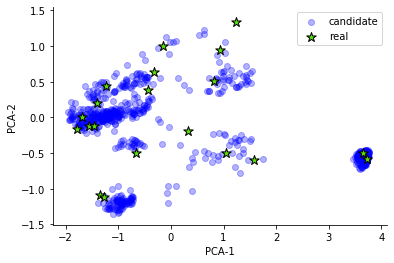

In [0]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
#plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='red', s=30, alpha=.3, label="synthetic");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
#plt.grid()
plt.legend();

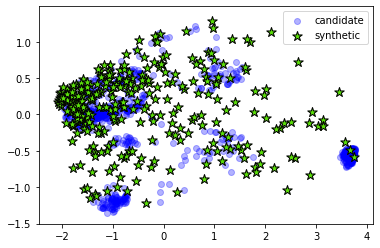

In [0]:
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='#5ADE09', s=100, alpha=1, marker="*",label="synthetic", edgecolors="black");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
#plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print("redução do ", (1 - cand.shape[0]/X_cand.shape[0])*100,"% no processo de escolha de candidatos")

redução do  80.42226487523992 % no processo de escolha de candidatos


In [0]:
obj_rg = open("./drive/My Drive/Colab Notebooks/data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [0]:
for i in rg:
  if i in rg_moose:
    print(i)

gyrB
dnaG


In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904


In [0]:
obj_edi = open("./drive/My Drive/Colab Notebooks/data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [0]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

clf2 = IsolationForest(n_estimators=100, contamination=0, random_state=False,
                      behaviour="new", n_jobs=2, warm_start=True)
clf2.fit(X_nov)

print("score no treinamento: ", np.mean(clf2.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf2.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf2.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf2.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf2.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(2956, 9) (1229, 9)
redução do  29.70273483947682 % no processo de escolha de candidatos


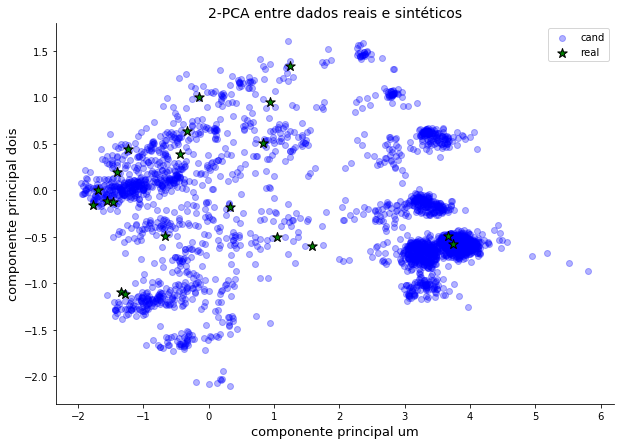

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
lhr,-1.035834,-1.041366,-1.066099,0.405957,-1.071559,-1.060662,-1.104705,-1.030697,-1.028057
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
pnp,1.012026,1.028689,-0.288030,-0.259168,-0.287101,-0.396191,0.954108,0.772673,0.990685


In [0]:
print(cand.loc[rg_edi].dropna().shape[0])
cand.loc[rg_edi].dropna()

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
efp,0.883929,0.893426,0.986886,0.953313,0.964894,0.900637,-0.666888,0.658397,0.797629
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
polA,0.657993,0.637631,0.712010,0.686595,0.690273,-0.891506,0.583032,-0.902868,0.601666
prc,0.701789,0.687073,0.768016,0.716171,0.720595,0.659306,-0.893690,-0.953165,0.564771
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
rimP,-0.661678,0.776155,0.880130,0.877383,0.870669,0.813908,0.679395,0.567525,-0.761204
rpsO,0.938523,0.932230,-0.408265,-0.417435,-0.436328,0.963185,0.966226,0.727576,0.862091


## LocalOutlierFactor

In [0]:
from sklearn.neighbors import LocalOutlierFactor

clf3 = LocalOutlierFactor(n_neighbors=2, contamination=0.00001, novelty=True,)
clf3.fit(X_nov)

print("score no treinamento: ", np.mean(clf3.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf3.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf3.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf3.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf3.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(3344, 9) (841, 9)
redução do  20.4756242568371 % no processo de escolha de candidatos


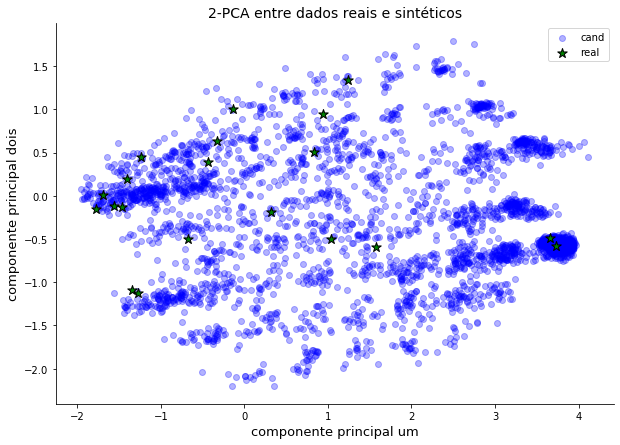

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
print(cand.loc[rg_edi].dropna().shape[0])

21
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [0]:
class one_class_gan:
    
    def __init__(self, X_train, noise_input, epochs):
        self.X_train = X_train
        self.noise_input = noise_input
        self.epochs = epochs
        #building gan
        optG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/self.epochs)
        optD = SGD(lr=0.00021, momentum=0.92, decay=0.0001/self.epochs)
        self.G = self.generator(optG)
        self.D = self.discriminator(optD)
        self.gan = self.build_gan(self.G, self.D, optG) 
        
    def generator(self, opt):
        model = Sequential()
        model.add(Dense(30, input_shape=(self.noise_input,)))
        model.add(Dense(30))
        model.add(Dense(X_train.shape[1], activation="tanh"))
        model.compile(loss="binary_crossentropy",
                      optimizer=opt)
        return model
    
    def discriminator(self, opt):
        model = Sequential()
        model.add(Dense(128, input_shape=(self.X_train.shape[1],)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(64))
        model.add(Dense(32))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
        return model
    
    def build_gan(self, G, D, opt):
        model = Sequential()
        model.add(G)
        D.trainable = False
        model.add(D)
        model.compile(loss="binary_crossentropy", optimizer=opt)
        return model
        
    def get_batches(self, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(self.X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > self.X_train.shape[0]:
                lim_s = self.X_train.shape[0]
            batches.append(self.X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
        return batches

    def train(self, epochs, batch_size):       
        g_loss = []
        d_loss = []
        precision = []
        for epoch in range(epochs):
            batches = self.get_batches(batch_size)
            count_b = 0
            t_i = time()
            d_bacth_loss = []
            g_bacth_loss = []
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_data = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_data))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_bacth_loss.append(self.D.train_on_batch(x_combined_batch, y_combined_batch)[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))
                g_bacth_loss.append(self.gan.train_on_batch(noise, y_mislabled))

            #precision
            X_sint = self.G.predict(np.random.normal(0, 1, (self.X_train.shape[0], self.noise_input)))
            X_comb = np.concatenate((self.X_train, X_sint))
            y_comb = np.concatenate((np.ones((self.X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
            y_predict = self.D.predict_classes(X_comb)
            #f1_lag = f1_score(y_test, y_predict)
            precision.append(precision_score(y_comb, y_predict))
            #fscore.append(f1_lag)
            t_f = time()
            t = t_f - t_i
            t_i = time()
            #d_loss.append(np.mean(np.array(d_bacth_loss)))
            #g_loss.append(np.mean(np.array(g_bacth_loss)))
            d_loss.append(d_bacth_loss[-1])
            g_loss.append(g_bacth_loss[-1])
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                       % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
            #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
            #    break
        return g_loss, d_loss, precision

In [0]:
X_nov.shape

(314, 9)

In [0]:
obj_oc = one_class_gan(X_nov, 50, 1000)
gloss, dloss, d_precision  = obj_oc.train(1000, batch_size=int(X_nov.shape[0]))

epoch:[1/1000] [Discriminator::d_loss: 0.746245],[Generator::loss: 0.860223], 1.930268[sec]
epoch:[2/1000] [Discriminator::d_loss: 0.740365],[Generator::loss: 0.873091], 0.031229[sec]
epoch:[3/1000] [Discriminator::d_loss: 0.748399],[Generator::loss: 0.902758], 0.031521[sec]
epoch:[4/1000] [Discriminator::d_loss: 0.745964],[Generator::loss: 0.878662], 0.031005[sec]
epoch:[5/1000] [Discriminator::d_loss: 0.741356],[Generator::loss: 0.887164], 0.031445[sec]
epoch:[6/1000] [Discriminator::d_loss: 0.739816],[Generator::loss: 0.865471], 0.029828[sec]
epoch:[7/1000] [Discriminator::d_loss: 0.740039],[Generator::loss: 0.882209], 0.029025[sec]
epoch:[8/1000] [Discriminator::d_loss: 0.743635],[Generator::loss: 0.859898], 0.032923[sec]
epoch:[9/1000] [Discriminator::d_loss: 0.737955],[Generator::loss: 0.871129], 0.038237[sec]
epoch:[10/1000] [Discriminator::d_loss: 0.732992],[Generator::loss: 0.849895], 0.028504[sec]
epoch:[11/1000] [Discriminator::d_loss: 0.745697],[Generator::loss: 0.892264], 

epoch:[92/1000] [Discriminator::d_loss: 0.668491],[Generator::loss: 0.770164], 0.040072[sec]
epoch:[93/1000] [Discriminator::d_loss: 0.668159],[Generator::loss: 0.792502], 0.033797[sec]
epoch:[94/1000] [Discriminator::d_loss: 0.674871],[Generator::loss: 0.795097], 0.034383[sec]
epoch:[95/1000] [Discriminator::d_loss: 0.671822],[Generator::loss: 0.780956], 0.030917[sec]
epoch:[96/1000] [Discriminator::d_loss: 0.663923],[Generator::loss: 0.773816], 0.028524[sec]
epoch:[97/1000] [Discriminator::d_loss: 0.673712],[Generator::loss: 0.785451], 0.028644[sec]
epoch:[98/1000] [Discriminator::d_loss: 0.660476],[Generator::loss: 0.779084], 0.028720[sec]
epoch:[99/1000] [Discriminator::d_loss: 0.672668],[Generator::loss: 0.776520], 0.036183[sec]
epoch:[100/1000] [Discriminator::d_loss: 0.668647],[Generator::loss: 0.769589], 0.029272[sec]
epoch:[101/1000] [Discriminator::d_loss: 0.664568],[Generator::loss: 0.779865], 0.028601[sec]
epoch:[102/1000] [Discriminator::d_loss: 0.660517],[Generator::loss:

epoch:[183/1000] [Discriminator::d_loss: 0.630127],[Generator::loss: 0.789274], 0.035751[sec]
epoch:[184/1000] [Discriminator::d_loss: 0.633323],[Generator::loss: 0.776569], 0.034500[sec]
epoch:[185/1000] [Discriminator::d_loss: 0.625448],[Generator::loss: 0.775465], 0.028606[sec]
epoch:[186/1000] [Discriminator::d_loss: 0.634966],[Generator::loss: 0.764065], 0.028067[sec]
epoch:[187/1000] [Discriminator::d_loss: 0.635576],[Generator::loss: 0.786489], 0.028328[sec]
epoch:[188/1000] [Discriminator::d_loss: 0.638709],[Generator::loss: 0.784521], 0.028665[sec]
epoch:[189/1000] [Discriminator::d_loss: 0.633055],[Generator::loss: 0.779182], 0.027912[sec]
epoch:[190/1000] [Discriminator::d_loss: 0.637991],[Generator::loss: 0.787109], 0.031408[sec]
epoch:[191/1000] [Discriminator::d_loss: 0.634035],[Generator::loss: 0.772943], 0.033014[sec]
epoch:[192/1000] [Discriminator::d_loss: 0.630496],[Generator::loss: 0.802919], 0.028116[sec]
epoch:[193/1000] [Discriminator::d_loss: 0.640743],[Generato

epoch:[273/1000] [Discriminator::d_loss: 0.611936],[Generator::loss: 0.792530], 0.030707[sec]
epoch:[274/1000] [Discriminator::d_loss: 0.601125],[Generator::loss: 0.791718], 0.032902[sec]
epoch:[275/1000] [Discriminator::d_loss: 0.603577],[Generator::loss: 0.817779], 0.028722[sec]
epoch:[276/1000] [Discriminator::d_loss: 0.614395],[Generator::loss: 0.782845], 0.028118[sec]
epoch:[277/1000] [Discriminator::d_loss: 0.619263],[Generator::loss: 0.774457], 0.028457[sec]
epoch:[278/1000] [Discriminator::d_loss: 0.609266],[Generator::loss: 0.789328], 0.028690[sec]
epoch:[279/1000] [Discriminator::d_loss: 0.620612],[Generator::loss: 0.788637], 0.029216[sec]
epoch:[280/1000] [Discriminator::d_loss: 0.611764],[Generator::loss: 0.805794], 0.038996[sec]
epoch:[281/1000] [Discriminator::d_loss: 0.619166],[Generator::loss: 0.802913], 0.035741[sec]
epoch:[282/1000] [Discriminator::d_loss: 0.623727],[Generator::loss: 0.795872], 0.029810[sec]
epoch:[283/1000] [Discriminator::d_loss: 0.614697],[Generato

epoch:[366/1000] [Discriminator::d_loss: 0.594193],[Generator::loss: 0.820352], 0.035710[sec]
epoch:[367/1000] [Discriminator::d_loss: 0.603797],[Generator::loss: 0.806911], 0.028681[sec]
epoch:[368/1000] [Discriminator::d_loss: 0.600800],[Generator::loss: 0.832233], 0.028423[sec]
epoch:[369/1000] [Discriminator::d_loss: 0.612345],[Generator::loss: 0.846448], 0.028194[sec]
epoch:[370/1000] [Discriminator::d_loss: 0.601696],[Generator::loss: 0.854197], 0.028432[sec]
epoch:[371/1000] [Discriminator::d_loss: 0.599297],[Generator::loss: 0.827697], 0.028231[sec]
epoch:[372/1000] [Discriminator::d_loss: 0.598163],[Generator::loss: 0.821190], 0.027991[sec]
epoch:[373/1000] [Discriminator::d_loss: 0.602412],[Generator::loss: 0.822970], 0.027811[sec]
epoch:[374/1000] [Discriminator::d_loss: 0.602343],[Generator::loss: 0.803259], 0.034872[sec]
epoch:[375/1000] [Discriminator::d_loss: 0.602546],[Generator::loss: 0.808376], 0.029219[sec]
epoch:[376/1000] [Discriminator::d_loss: 0.594167],[Generato

epoch:[455/1000] [Discriminator::d_loss: 0.597345],[Generator::loss: 0.869968], 0.057521[sec]
epoch:[456/1000] [Discriminator::d_loss: 0.579352],[Generator::loss: 0.850302], 0.055524[sec]
epoch:[457/1000] [Discriminator::d_loss: 0.600926],[Generator::loss: 0.830175], 0.061816[sec]
epoch:[458/1000] [Discriminator::d_loss: 0.593250],[Generator::loss: 0.824044], 0.043757[sec]
epoch:[459/1000] [Discriminator::d_loss: 0.576606],[Generator::loss: 0.833591], 0.031454[sec]
epoch:[460/1000] [Discriminator::d_loss: 0.595502],[Generator::loss: 0.827471], 0.053752[sec]
epoch:[461/1000] [Discriminator::d_loss: 0.585673],[Generator::loss: 0.829274], 0.044130[sec]
epoch:[462/1000] [Discriminator::d_loss: 0.594883],[Generator::loss: 0.858246], 0.037819[sec]
epoch:[463/1000] [Discriminator::d_loss: 0.576726],[Generator::loss: 0.849462], 0.048540[sec]
epoch:[464/1000] [Discriminator::d_loss: 0.580452],[Generator::loss: 0.838950], 0.036973[sec]
epoch:[465/1000] [Discriminator::d_loss: 0.587953],[Generato

epoch:[548/1000] [Discriminator::d_loss: 0.576298],[Generator::loss: 0.862914], 0.063190[sec]
epoch:[549/1000] [Discriminator::d_loss: 0.572611],[Generator::loss: 0.874074], 0.058437[sec]
epoch:[550/1000] [Discriminator::d_loss: 0.582935],[Generator::loss: 0.859206], 0.059222[sec]
epoch:[551/1000] [Discriminator::d_loss: 0.584263],[Generator::loss: 0.847397], 0.031224[sec]
epoch:[552/1000] [Discriminator::d_loss: 0.588994],[Generator::loss: 0.833101], 0.028154[sec]
epoch:[553/1000] [Discriminator::d_loss: 0.579975],[Generator::loss: 0.810964], 0.034197[sec]
epoch:[554/1000] [Discriminator::d_loss: 0.568848],[Generator::loss: 0.859562], 0.034598[sec]
epoch:[555/1000] [Discriminator::d_loss: 0.582876],[Generator::loss: 0.818677], 0.029262[sec]
epoch:[556/1000] [Discriminator::d_loss: 0.581828],[Generator::loss: 0.847107], 0.028605[sec]
epoch:[557/1000] [Discriminator::d_loss: 0.569553],[Generator::loss: 0.856633], 0.028262[sec]
epoch:[558/1000] [Discriminator::d_loss: 0.584717],[Generato

epoch:[642/1000] [Discriminator::d_loss: 0.573168],[Generator::loss: 0.844857], 0.043798[sec]
epoch:[643/1000] [Discriminator::d_loss: 0.569933],[Generator::loss: 0.861991], 0.031276[sec]
epoch:[644/1000] [Discriminator::d_loss: 0.576534],[Generator::loss: 0.853919], 0.029686[sec]
epoch:[645/1000] [Discriminator::d_loss: 0.564274],[Generator::loss: 0.863864], 0.029221[sec]
epoch:[646/1000] [Discriminator::d_loss: 0.568633],[Generator::loss: 0.881825], 0.029371[sec]
epoch:[647/1000] [Discriminator::d_loss: 0.583529],[Generator::loss: 0.899321], 0.029746[sec]
epoch:[648/1000] [Discriminator::d_loss: 0.583146],[Generator::loss: 0.842704], 0.029701[sec]
epoch:[649/1000] [Discriminator::d_loss: 0.569734],[Generator::loss: 0.860586], 0.038804[sec]
epoch:[650/1000] [Discriminator::d_loss: 0.570809],[Generator::loss: 0.891290], 0.037782[sec]
epoch:[651/1000] [Discriminator::d_loss: 0.580916],[Generator::loss: 0.863038], 0.029677[sec]
epoch:[652/1000] [Discriminator::d_loss: 0.574856],[Generato

epoch:[733/1000] [Discriminator::d_loss: 0.574266],[Generator::loss: 0.867837], 0.033404[sec]
epoch:[734/1000] [Discriminator::d_loss: 0.573628],[Generator::loss: 0.860497], 0.056169[sec]
epoch:[735/1000] [Discriminator::d_loss: 0.565907],[Generator::loss: 0.875685], 0.054189[sec]
epoch:[736/1000] [Discriminator::d_loss: 0.561576],[Generator::loss: 0.853484], 0.049826[sec]
epoch:[737/1000] [Discriminator::d_loss: 0.581940],[Generator::loss: 0.883906], 0.031902[sec]
epoch:[738/1000] [Discriminator::d_loss: 0.583284],[Generator::loss: 0.858480], 0.037786[sec]
epoch:[739/1000] [Discriminator::d_loss: 0.580848],[Generator::loss: 0.868067], 0.029289[sec]
epoch:[740/1000] [Discriminator::d_loss: 0.572089],[Generator::loss: 0.857667], 0.029251[sec]
epoch:[741/1000] [Discriminator::d_loss: 0.562960],[Generator::loss: 0.870371], 0.029215[sec]
epoch:[742/1000] [Discriminator::d_loss: 0.593431],[Generator::loss: 0.869779], 0.029026[sec]
epoch:[743/1000] [Discriminator::d_loss: 0.574447],[Generato

epoch:[822/1000] [Discriminator::d_loss: 0.566237],[Generator::loss: 0.890377], 0.029127[sec]
epoch:[823/1000] [Discriminator::d_loss: 0.575509],[Generator::loss: 0.869005], 0.032736[sec]
epoch:[824/1000] [Discriminator::d_loss: 0.592644],[Generator::loss: 0.906220], 0.028920[sec]
epoch:[825/1000] [Discriminator::d_loss: 0.570785],[Generator::loss: 0.877945], 0.028919[sec]
epoch:[826/1000] [Discriminator::d_loss: 0.571615],[Generator::loss: 0.870386], 0.028424[sec]
epoch:[827/1000] [Discriminator::d_loss: 0.572146],[Generator::loss: 0.914298], 0.028231[sec]
epoch:[828/1000] [Discriminator::d_loss: 0.574680],[Generator::loss: 0.876985], 0.028346[sec]
epoch:[829/1000] [Discriminator::d_loss: 0.577047],[Generator::loss: 0.879536], 0.029092[sec]
epoch:[830/1000] [Discriminator::d_loss: 0.574611],[Generator::loss: 0.881863], 0.033524[sec]
epoch:[831/1000] [Discriminator::d_loss: 0.580498],[Generator::loss: 0.870103], 0.029768[sec]
epoch:[832/1000] [Discriminator::d_loss: 0.577555],[Generato

epoch:[913/1000] [Discriminator::d_loss: 0.584998],[Generator::loss: 0.901712], 0.034184[sec]
epoch:[914/1000] [Discriminator::d_loss: 0.587001],[Generator::loss: 0.865476], 0.035640[sec]
epoch:[915/1000] [Discriminator::d_loss: 0.564490],[Generator::loss: 0.887608], 0.029130[sec]
epoch:[916/1000] [Discriminator::d_loss: 0.573451],[Generator::loss: 0.863777], 0.029696[sec]
epoch:[917/1000] [Discriminator::d_loss: 0.600882],[Generator::loss: 0.886710], 0.028510[sec]
epoch:[918/1000] [Discriminator::d_loss: 0.581894],[Generator::loss: 0.865691], 0.028248[sec]
epoch:[919/1000] [Discriminator::d_loss: 0.578947],[Generator::loss: 0.872884], 0.029007[sec]
epoch:[920/1000] [Discriminator::d_loss: 0.586104],[Generator::loss: 0.880017], 0.033375[sec]
epoch:[921/1000] [Discriminator::d_loss: 0.592893],[Generator::loss: 0.878161], 0.031502[sec]
epoch:[922/1000] [Discriminator::d_loss: 0.582204],[Generator::loss: 0.891742], 0.028577[sec]
epoch:[923/1000] [Discriminator::d_loss: 0.578287],[Generato

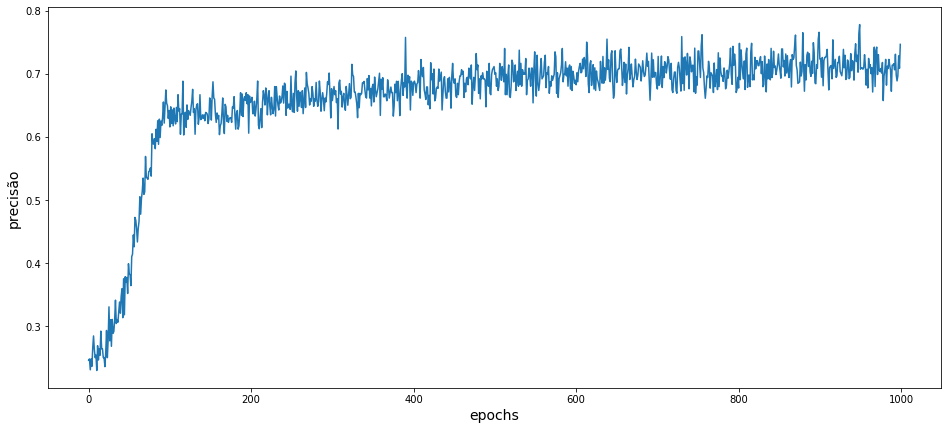

In [0]:
plt.figure(figsize=(16,7))
plt.xlabel("epochs", fontsize=14)
plt.ylabel("precisão", fontsize=14)
plt.plot(range(len(d_precision)), d_precision);

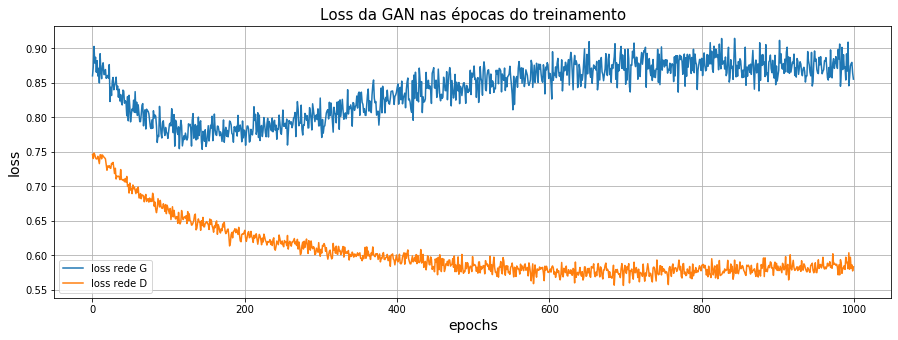

In [0]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(gloss)), gloss, label="loss rede G")
plt.plot(range(len(dloss)), dloss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

In [0]:
np.mean(obj_oc.D.predict_classes(X_train)==1)

0.6

In [0]:
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669
